# Traffic sign detection and classification

In [1]:
from xml.dom import minidom
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = []
test = []

with open("test.txt") as _file:
    for line in _file:
        train.append(line.replace('\n', ''))

# noinspection JupyterPackage
with open("train.txt") as _file:
    for line in _file:
        test.append(line.replace('\n', ''))

def create_dataframe(data):
    signs = []
    for name in data:
        file = minidom.parse("annotations/" + name + ".xml")
        path = "images/" + file.getElementsByTagName('filename')[0].firstChild.data
        filename = file.getElementsByTagName('filename')[0].firstChild.data
        name = file.getElementsByTagName('name')
        classes = []
        for n in name:
            classes.append(n.firstChild.data)
        number_of_signs = len(classes)

        signs.append([filename, " ".join(classes), path, number_of_signs])

    return pd.DataFrame(signs, columns=['filename', 'classes', 'path', 'number_of_signs'])

df_train = create_dataframe(train)
df_test = create_dataframe(test)

## Pre-Trained Model RestNet34 on ImageNet dataset.

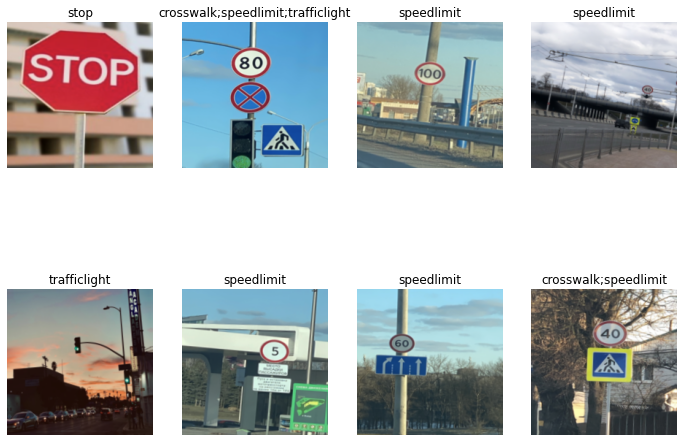

In [3]:
from fastai.vision.all import *

bs = 16
batch_tfms = aug_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0., do_flip=False)
item_tfms = [ Resize((200, 200), method='squish')]

datablock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref='images/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = item_tfms,
                    batch_tfms = batch_tfms)

dls_train = datablock.dataloaders(df_train, bs=bs)
dls_test = dls_train.test_dl(df_test, with_labels=True, bs=bs)

dls_train.show_batch(max_n=9, figsize=(12,9))

SuggestedLRs(valley=0.0014454397605732083)

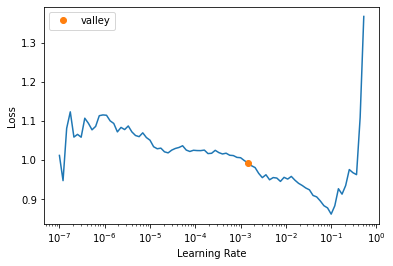

In [4]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls_train, resnet50, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

learn.loss_func = BCEWithLogitsLossFlat()

learn.lr_find()

In [5]:
lr = 1e-3
learn = learn.to_fp16()

In [6]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,1.015902,0.596257,0.673077,0.500414,0.561538,00:02
1,0.865985,0.599378,0.697115,0.548017,0.639103,00:02
2,0.764461,0.627738,0.711538,0.544729,0.611538,00:02
3,0.685355,0.463903,0.778846,0.620031,0.749359,00:02
4,0.601729,0.361121,0.841346,0.684931,0.806410,00:02
5,0.523633,0.333477,0.855769,0.717222,0.835256,00:02
6,0.447716,0.295011,0.879808,0.743989,0.861538,00:02
7,0.384891,0.280976,0.899038,0.769318,0.880769,00:02
8,0.359172,0.247794,0.923077,0.817183,0.906410,00:02
9,0.329667,0.276018,0.894231,0.774644,0.877564,00:02


In [7]:
learn.save('stage-1')

Path('models/stage-1.pth')

SuggestedLRs(valley=7.585775892948732e-05)

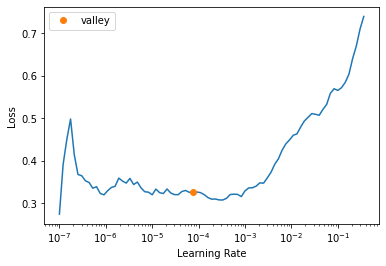

In [8]:
learn.unfreeze()
learn.lr_find()

In [9]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.299589,0.258083,0.913462,0.802089,0.900000,00:02
1,0.302470,0.233931,0.937500,0.839066,0.916667,00:02
2,0.279972,0.191850,0.942308,0.879909,0.926282,00:02
3,0.255209,0.177994,0.947115,0.873773,0.926282,00:02
4,0.241768,0.192645,0.927885,0.832711,0.906410,00:02
5,0.239045,0.187867,0.942308,0.879909,0.926282,00:02
6,0.233664,0.149715,0.947115,0.860861,0.926282,00:02
7,0.222282,0.133251,0.966346,0.922400,0.958333,00:02
8,0.217615,0.129527,0.966346,0.922400,0.958333,00:02
9,0.208712,0.142830,0.961538,0.895147,0.951923,00:02


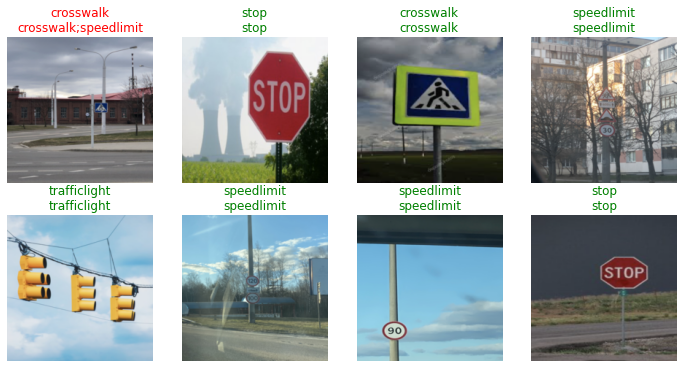

In [10]:
learn.show_results()

,target,predicted,probabilities,loss
0,speedlimit;trafficlight,crosswalk;speedlimit,"TensorBase([0.8062, 0.8774, 0.1895, 0.2473])",0.8448554277420044
1,crosswalk,crosswalk;speedlimit,"TensorBase([0.5357, 0.7900, 0.2737, 0.0702])",0.6444002389907837
2,speedlimit,crosswalk;speedlimit,"TensorBase([0.8392, 0.7902, 0.0376, 0.1200])",0.5573245882987976
3,stop,stop;trafficlight,"TensorBase([0.0218, 0.0151, 0.9012, 0.8629])",0.5321327447891235
4,crosswalk;speedlimit,crosswalk;speedlimit,"TensorBase([0.8524, 0.9764, 0.4239, 0.4753])",0.34501001238822937
5,trafficlight,stop;trafficlight,"TensorBase([0.0901, 0.0027, 0.6078, 0.9826])",0.26269927620887756
6,speedlimit,speedlimit,"TensorBase([0.4259, 0.9230, 0.0496, 0.2408])",0.2403397262096405
7,speedlimit,speedlimit;stop,"TensorBase([0.0278, 0.9663, 0.5097, 0.1095])",0.22278688848018646
8,crosswalk;speedlimit,speedlimit,"TensorBase([0.4378, 0.9930, 0.0126, 0.0147])",0.21509908139705658


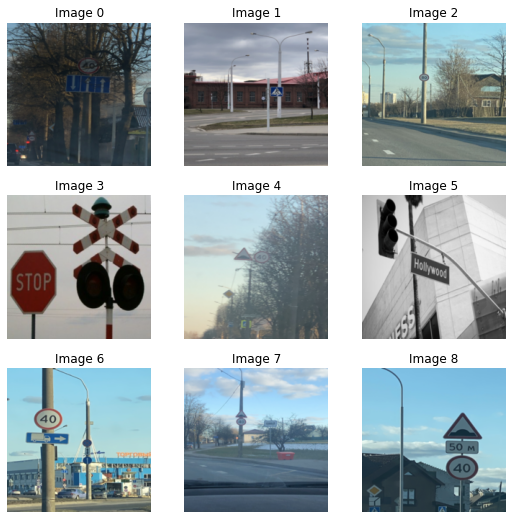

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9);

In [12]:
loss, acc, _, _ = learn.validate(dl=dls_test)

print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 0.3580676019191742, Accuracy: 86.21533513069153 %
